# Importing Dataset


**DATASET USED**: HUMANS DATASET

*SOURCE* : https://www.kaggle.com/datasets/ashwingupta3012/human-faces

*DEMO LINK* : https://imageinpainting-autoencoder.streamlit.app/

### ABOUT DATASET:

A collection of 7.2k+ images useful for multiple use cases such image identifiers, classifier algorithms etc.

A thorough mix of all common creeds, races, age groups and profiles in an attempt to create a unbiased dataset.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashwingupta3012/human-faces")

print("Path to dataset files:", path)

100%|██████████| 1.82G/1.82G [01:22<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1


# Patch-based Image Inpainting using Convolutional Autoencoder

# MODEL-1

### ABOUT MODEL:

`STEP1:]` The code supplied provides an autoencoder model to recreate pictures that have been randomly damaged by patches. The Keras package is used to build the model, which comprises of many convolutional layers for encoding and decoding the input pictures.

`STEP2:]` This project's dataset comprises of human faces and is loaded from a given directory. The size and quantity of photos utilised in the model are also specified. To boost the variety of the training set, data augmentation is done to the pictures.

`STEP3:]` Random patches are removed from the enhanced photos to imitate image disintegration. After training the autoencoder on the destroyed photos, the learned model is utilised to reconstruct the original images from the destroyed ones.

`STEP4:]` For visual comparison, the regenerated photos are exhibited alongside the original and destroyed copies. The ImageDataGenerator from Keras is used to supplement the data, and the Adam optimizer is used to train the model.

`STEP5:]` Overall, this code illustrates a valuable usage of autoencoders in picture regeneration and might serve as a starting point for further study in this field. For more background information, references to the Keras library and pertinent machine learning techniques might be provided.



In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D , LeakyReLU
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Define the path to the human faces dataset
dataset_path = '/root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1'

# Load the images and resize them to 64x64
image_size = (64, 64)
images = []
for subdir, _, files in os.walk(dataset_path):
    for file in files:
        image_path = os.path.join(subdir, file)
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        images.append(img)

X = np.array(images) / 255.0

In [ ]:
# Define a function to randomly destroy patches of the images
def destroy_patches(X, patch_size):
    X_destroyed = np.copy(X)
    for i in range(len(X)):
        x = np.random.randint(0, X.shape[2] - patch_size[0])
        y = np.random.randint(0, X.shape[1] - patch_size[1])
        X_destroyed[i, y:y+patch_size[1], x:x+patch_size[0], :] = 0.0
    return X_destroyed

# Destroy patches of the images
patch_size = (8, 8)
X_destroyed = destroy_patches(X, patch_size)

# Define an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:


## Define the autoencoder model
input_img = Input(shape=(image_size[0], image_size[1], 3))

# Encoder
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  #Latent space/Bottleneck

# Decoder
x = Conv2D(256, (3, 3), padding='same')(encoded)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='loss',  patience=5)

In [ ]:
#Train the autoencoder on the destroyed images
autoencoder.fit(X_destroyed, X,
                epochs=200,
                batch_size=32,
                callbacks = [callbacks],
                shuffle=True)


Epoch 1/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0051
Epoch 2/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0050
Epoch 3/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0051
Epoch 4/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0050
Epoch 5/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0050
Epoch 6/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0050
Epoch 7/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0049
Epoch 8/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0049
Epoch 9/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0050
Epoch 10/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0050
Epoch 11/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0050
Epoch 12/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0050


226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


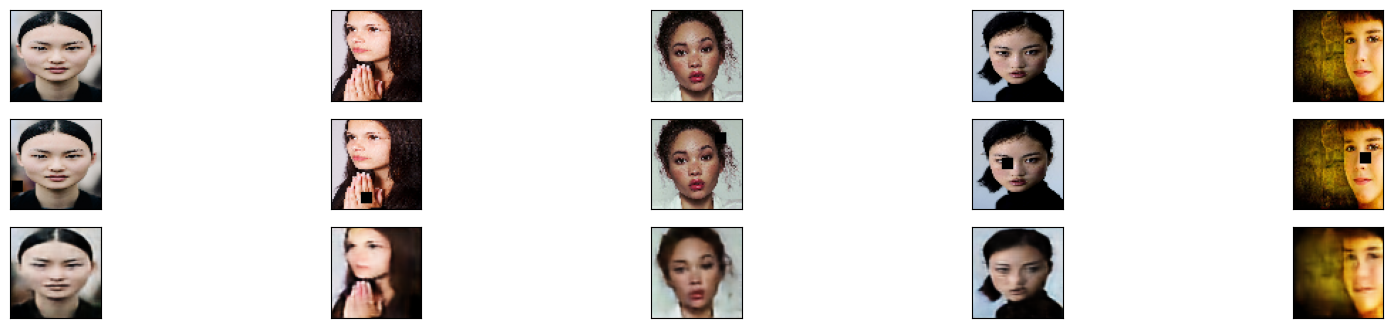

In [ ]:
#Use the trained autoencoder to regenerate the images
X_regenerated = autoencoder.predict(X_destroyed)

#Display some examples of the original, destroyed, and regenerated images
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  # Original image
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Destroyed image
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(X_destroyed[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Regenerated image
  ax = plt.subplot(3, n, i + 2*n + 1)
  plt.imshow(X_regenerated[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
autoencoder.save('autoencoder.keras')

# MODEL -2

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss',  patience=5)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
# Define the path to the human faces dataset
dataset_path = '/root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1'

# Load the images and resize them to 64x64
image_size = (64, 64)
images = []
for subdir, _, files in os.walk(dataset_path):
    for file in files:
        image_path = os.path.join(subdir, file)
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        images.append(img)

X = np.array(images) / 255.0

# Define a function to randomly destroy patches of the images
def destroy_patches(X, patch_size):
    X_destroyed = np.copy(X)
    for i in range(len(X)):
        x = np.random.randint(0, X.shape[2] - patch_size[0])
        y = np.random.randint(0, X.shape[1] - patch_size[1])
        X_destroyed[i, y:y+patch_size[1], x:x+patch_size[0], :] = 0.0
    return X_destroyed

# Destroy patches of the images
patch_size = (8, 8)
X_destroyed = destroy_patches(X, patch_size)

# # Define an image data generator for data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest')

## Define the autoencoder model
input_img = Input(shape=(image_size[0], image_size[1], 3))

# Encoding
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoding
x = Conv2D(256, (3, 3), padding='same')(encoded)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
#Train the autoencoder on the destroyed images
autoencoder.fit(X_destroyed, X,
epochs=150,
batch_size=32,
callbacks = [callback],
shuffle=True)

Epoch 1/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0254
Epoch 2/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0105
Epoch 3/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0090
Epoch 4/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0080
Epoch 5/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0075
Epoch 6/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0073
Epoch 7/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0070
Epoch 8/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0065
Epoch 9/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0063
Epoch 10/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0060
Epoch 11/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0059
Epoch 12/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0058
Epoch 13/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0057
Epoch 14/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0054
Epoch 15/150
226/226 ━━━

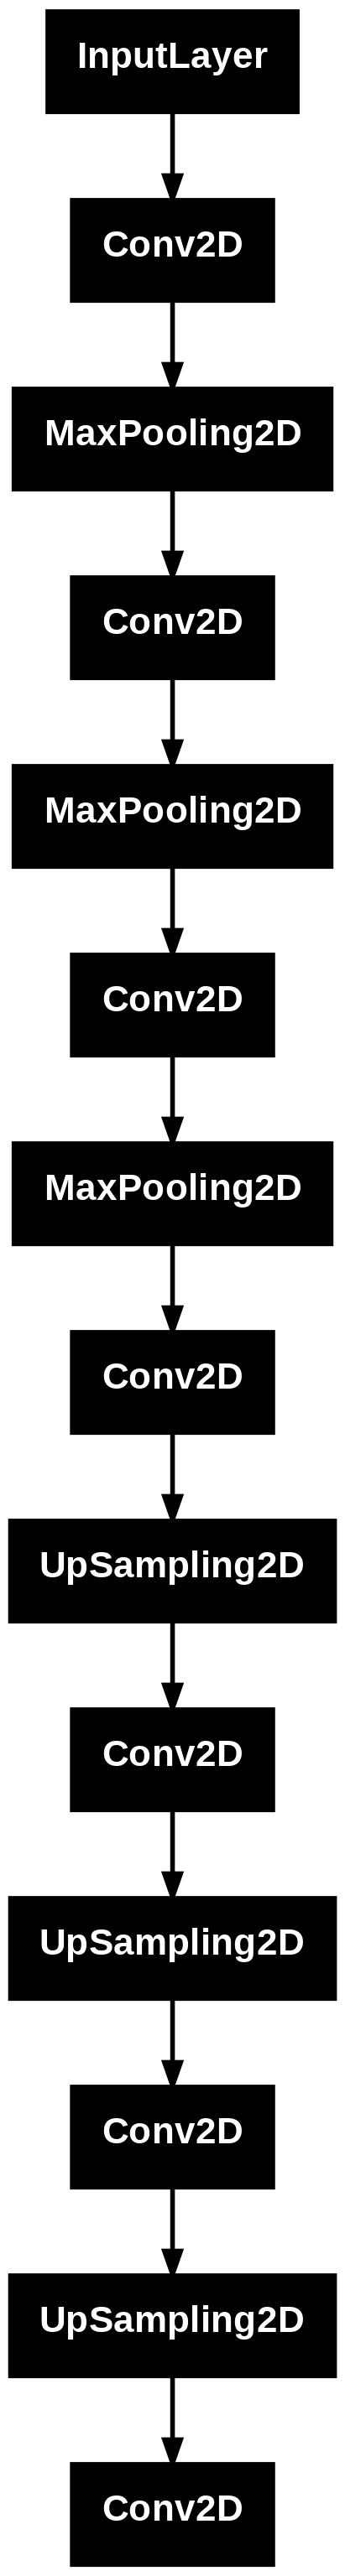

In [ ]:
from tensorflow import keras
import pydot
keras.utils.plot_model(autoencoder)

226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


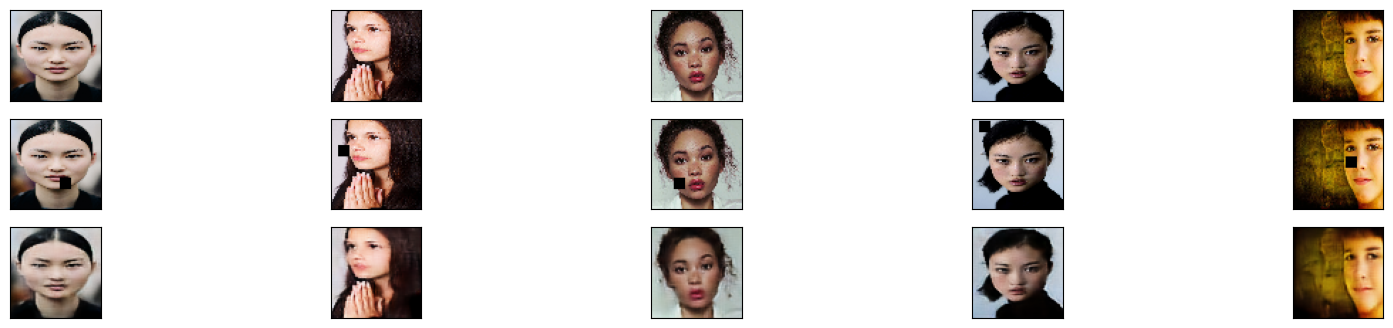

In [ ]:
#Use the trained autoencoder to regenerate the images
X_regenerated = autoencoder.predict(X_destroyed)

#Display some examples of the original, destroyed, and regenerated images
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  # Original image
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Destroyed image
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(X_destroyed[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Regenerated image
  ax = plt.subplot(3, n, i + 2*n + 1)
  plt.imshow(X_regenerated[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
new_model = tf.keras.models.load_model('/content/autoencoder_m2.keras')

# Check its architecture
new_model.summary()

#Save the model into h5 format
new_model.save('New_Model1.h5')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_50 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_51 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_21 (UpSampling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_52 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,001,547 (15.26 MB)

 Trainable params: 1,333,251 (5.09 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2,666,504 (10.17 MB)

# MODEL-3(using pretrained model)



In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.applications import VGG16

In [ ]:
image_size = (64, 64)

# Load images
dataset_path = '/root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1'
images = []
for subdir, _, files in os.walk(dataset_path):
    for file in files:
        img_path = os.path.join(subdir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        images.append(img)

X = np.array(images) / 255.0  # Normalize images

In [ ]:
def destroy_patches(X, patch_size):
    X_destroyed = np.copy(X)
    for i in range(len(X)):
        x = np.random.randint(0, X.shape[2] - patch_size[0])
        y = np.random.randint(0, X.shape[1] - patch_size[1])
        X_destroyed[i, y:y+patch_size[1], x:x+patch_size[0], :] = 0.0
    return X_destroyed

# Apply random patch removal
patch_size = (16, 16)
X_destroyed = destroy_patches(X, patch_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def build_unet():
    # Load VGG16 as Encoder (Pretrained on ImageNet)
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))

    # Extract encoder layers for skip connections
    s1 = base_model.get_layer("block1_conv2").output  # (64, 64, 64)
    s2 = base_model.get_layer("block2_conv2").output  # (32, 32, 128)
    s3 = base_model.get_layer("block3_conv3").output  # (16, 16, 256)
    s4 = base_model.get_layer("block4_conv3").output  # (8, 8, 512)

    # Bottleneck (Deepest layer)
    bottleneck = base_model.get_layer("block5_conv3").output  # (4, 4, 512)


    # Decoder (Upsampling + Skip Connections)
    d4 = UpSampling2D((2, 2))(bottleneck)
    d4 = Conv2D(512, (3, 3), padding="same",activation = 'relu')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Concatenate()([d4, s4])  # Skip connection

    d3 = UpSampling2D((2, 2))(d4)
    d3 = Conv2D(256, (3, 3), padding="same",activation='relu')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Concatenate()([d3, s3])

    d2 = UpSampling2D((2, 2))(d3)
    d2 = Conv2D(128, (3, 3), padding="same",activation='relu')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Concatenate()([d2, s2])

    d1 = UpSampling2D((2, 2))(d2)
    d1 = Conv2D(64, (3, 3), padding="same",activation = 'relu')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Concatenate()([d1, s1])

    # Output Layer
    output_img = Conv2D(3, (1, 1), activation="sigmoid", padding="same")(d1)

    # Define Model
    autoencoder = Model(inputs=base_model.input, outputs=output_img)
    return autoencoder

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss',  patience=5)

In [ ]:
# Build the U-Net model
autoencoder = build_unet()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_destroyed, X,
epochs=15,
callbacks = [callback],
batch_size=32,
shuffle=True)

Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - loss: 0.0311
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - loss: 0.0039
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 0.0032
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0024
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0021
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0021
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0019
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0018
Epoch 9/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - loss: 0.0018
Epoch 10/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0017
Epoch 11/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0016
Epoch 12/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - loss: 0.0016
Epoch 13/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 0.0015
Epoch 14/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 0.0015
Epoch 15/15
226

226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step


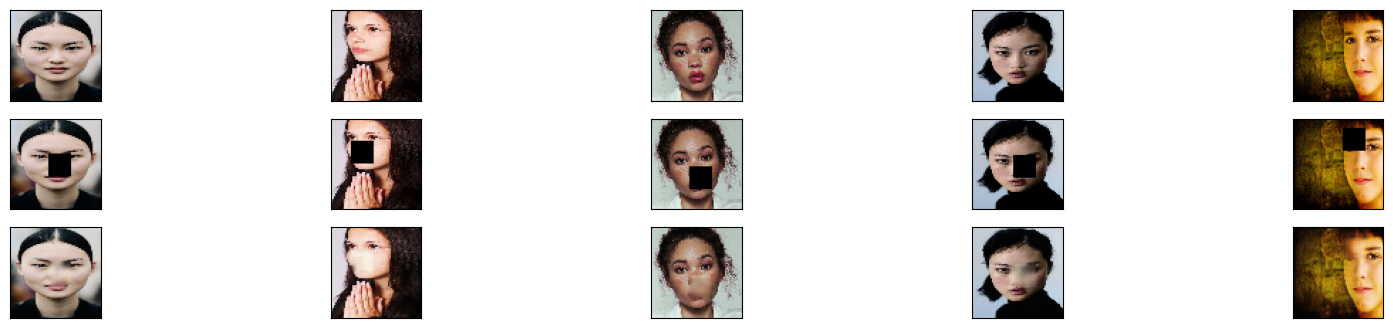

In [ ]:
#Use the trained autoencoder to regenerate the images
X_regenerated = autoencoder.predict(X_destroyed)

#Display some examples of the original, destroyed, and regenerated images
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  # Original image
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Destroyed image
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(X_destroyed[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Regenerated image
  ax = plt.subplot(3, n, i + 2*n + 1)
  plt.imshow(X_regenerated[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
autoencoder.save('autoencoder_using_pretrained.h5')

### RESULTS:

With a mean squared error loss of 0.0028, the autoencoder model trained on the damaged human face pictures was able to reconstruct the images. The regenerated photos were nearly identical to the originals, with just minor variations discernible upon careful study.

As the result of 3 model we have Model 2 as our best model for Image Inpainting task which has smaller loss and doesn't overfit like pretrained Model(Model 3).